## DFF1 - 3/5 Tournages films 2011

Auteur : Florian Gauthier

Date: 21/12/2016

Data: https://www.data.gouv.fr/fr/datasets/lieux-de-tournage-de-films-long-metrage-prs/

In [1]:
import pandas as pd
import datetime
from matplotlib import pyplot as plt, gridspec
import seaborn as sns

%matplotlib inline

In [2]:
tournages = pd.read_csv('../../DATA/tournagesdefilmsparis2011.csv', sep=';')
tournages.head(2)

,titre,realisateur,date_debut_evenement,date_fin_evenement,cadre,lieu,adresse,arrondissement,adresse_complete,geo_coordinates
0,BUS PALLADIUM,CHRISTOPHER THOMPSON,2009-05-21,2009-05-21,EXTERIEUR,PLACE,PIGALLE,75018,PLACE PIGALLE 75018 Paris France,NaN
1,LES INVITES DE MON PERE,ANNE LE NY,2009-05-20,2009-05-20,DOMAINE PUBLIC,SQUARE,DU CLIGNANCOURT,75018,SQUARE DU CLIGNANCOURT 75018 Paris France,NaN


# Calcul de quelques variables utiles

In [3]:
tournages['date_debut_evenement'] = pd.to_datetime(tournages['date_debut_evenement'])
tournages['date_fin_evenement'] = pd.to_datetime(tournages['date_fin_evenement'])
tournages['annee_evenement'] = tournages['date_debut_evenement'].dt.year
tournages['mois_evenement'] = tournages['date_debut_evenement'].dt.month

In [4]:
def compute_duree_tournage(row):
    day_range = pd.date_range(row['date_debut_evenement'], row['date_fin_evenement'], freq='D')
    return len(day_range)

In [5]:
tournages['n_days'] = tournages.apply(compute_duree_tournage, axis=1)

# Quand ont lieu les tournages ?

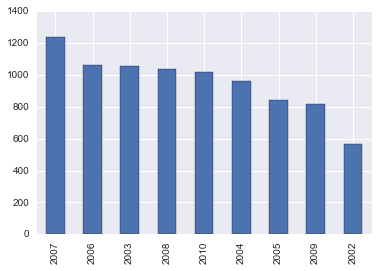

In [6]:
tournages.annee_evenement.value_counts().plot(kind='bar')

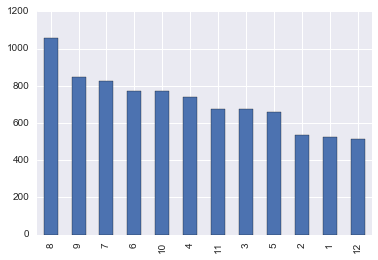

In [7]:
tournages.mois_evenement.value_counts().plot(kind='bar')

# Les arrondissements les plus prisés

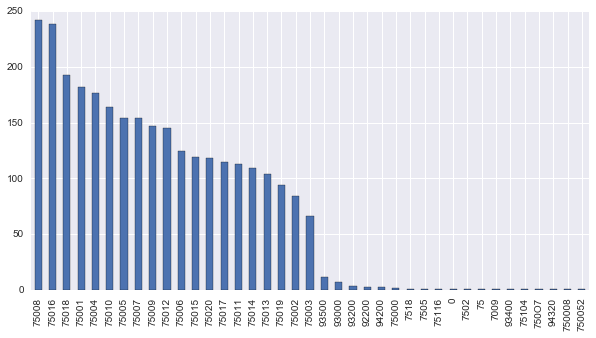

In [8]:
# On ne compte qu'une fois un (film x arrondissement)
tournages_arrondissement = tournages.drop_duplicates(subset=['titre', 'arrondissement'])
tournages_arrondissement.arrondissement.value_counts().plot(kind='bar', figsize=(10, 5))

# Les saisons les plus prisées

In [9]:
season_dict = {
    1:'hiver',
    2:'hiver',
    3:'hiver',
    4:'printemps',
    5:'printemps',
    6:'printemps',
    7:'été',
    8:'été',
    9:'été',
    10:'automne',
    11:'automne',
    12:'automne'}

tournages['saisons'] = tournages.mois_evenement.map(season_dict)

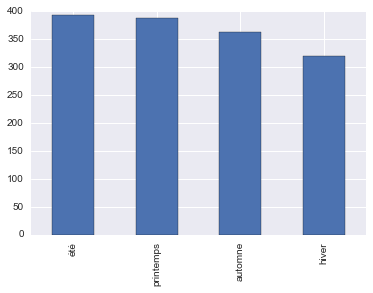

In [10]:
# On ne compte qu'une fois les (titre x saison)
tournages_saisons = tournages.drop_duplicates(subset=['titre', 'saisons'])
tournages_saisons.saisons.value_counts().plot(kind='bar')

In [11]:
def compare_seasons_plot(df, serie_name, max_values=10, kind='bar'):
    plt.figure(figsize=(10, 6))
    gs = gridspec.GridSpec(2, 2)
    col_as_list = ['blue', 'red', 'green', 'black', 'orange']
    plot_num = 0
    for saison in df.saisons.unique():
        df_saison = df.loc[df.saisons == saison].copy()
        ax = plt.subplot(gs[plot_num])
        total_days_year = df_saison.groupby(serie_name)['n_days'].sum().reset_index(
            name='total_days').sort_values('total_days', ascending=False)
        total_days_year.iloc[:10].plot(
            x=serie_name, y='total_days', kind=kind, ax=ax, color=col_as_list[plot_num])
        plot_num += 1
        plt.title('%s' % saison)
        if kind == 'barh':
            plt.gca().invert_yaxis()
    gs.update(wspace=1.5, hspace=0.9)

    
def compare_years_plot(df, serie_name, max_values=10, kind='bar'):
    plt.figure(figsize=(10, 15))
    gs = gridspec.GridSpec(5, 2)
    col_as_list = ['blue', 'red', 'green', 'black', 'orange', 'yellow', 'grey', 'purple', 'lightblue']
    plot_num = 0
    for year in df.annee_evenement.value_counts().sort_index().index:
        df_year = df.loc[df.annee_evenement == year].copy()
        ax = plt.subplot(gs[plot_num])
        total_days_year = df_year.groupby(serie_name)['n_days'].sum().reset_index(
            name='total_days').sort_values('total_days', ascending=False)
        total_days_year.iloc[:10].plot(
            x=serie_name, y='total_days', kind=kind, ax=ax, color=col_as_list[plot_num])
        plot_num += 1
        plt.title('%s' % year)
        if kind == 'barh':
            plt.gca().invert_yaxis()
    gs.update(wspace=1.0, hspace=0.9)

    
def plot_2_series(df, serie_x, serie_hue, plot_size=5):
    df_count = df.groupby([serie_x, serie_hue])['n_days'].sum().reset_index(name='n_tournages')
    sns.factorplot(
    x=serie_x, y="n_tournages", hue=serie_hue, data=df_count, size=plot_size, kind="bar", palette="muted")

# Nombre de jours de tournage par année & saison

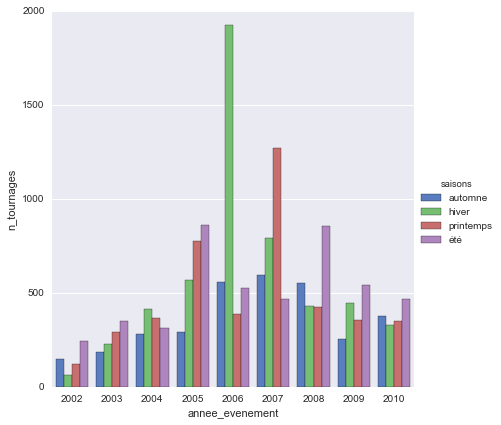

In [12]:
plot_2_series(tournages, "annee_evenement", serie_hue="saisons", plot_size=6)

# Les tournages les plus longs (en termes de sessions)

## Toutes années confondues

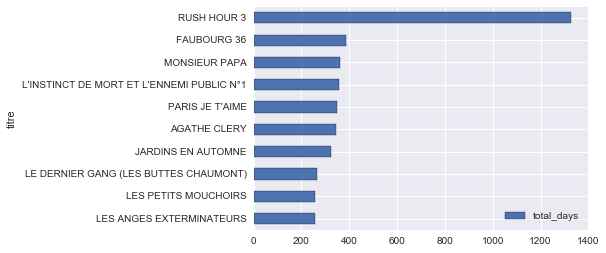

In [13]:
n_jours_tournages = tournages.groupby('titre')['n_days'].sum().reset_index(name='total_days').sort_values('total_days', ascending=False)
n_jours_tournages.iloc[:10].plot(x='titre', y='total_days', kind='barh')
plt.gca().invert_yaxis()

## Par année

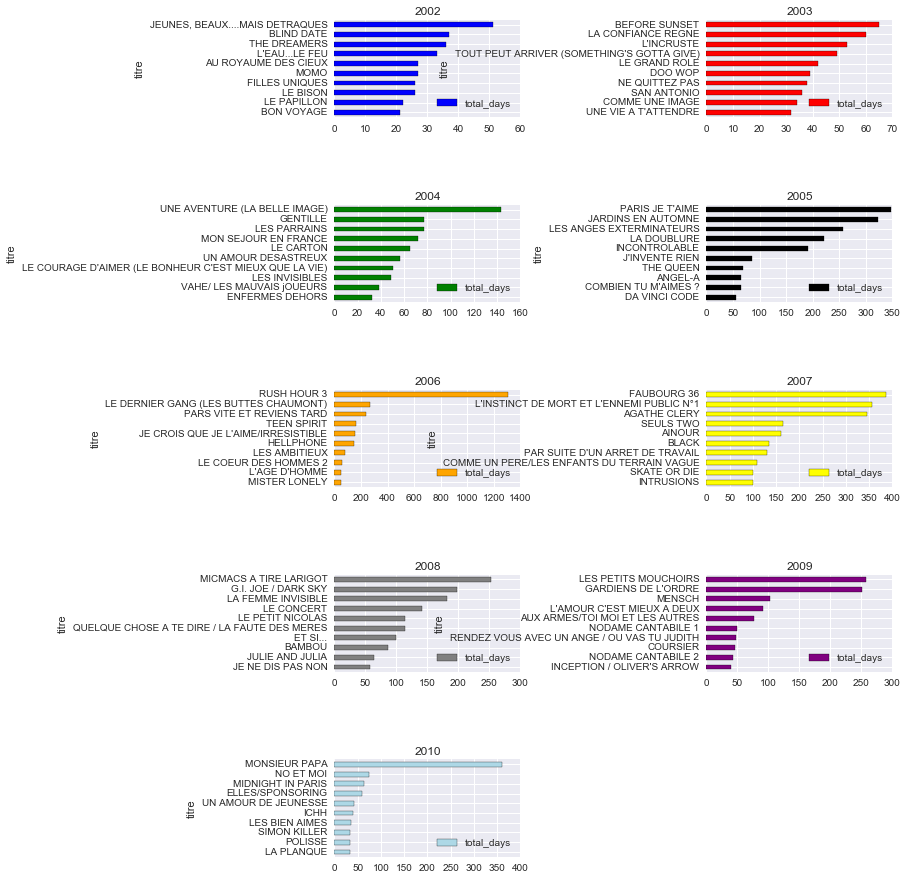

In [14]:
compare_years_plot(tournages, 'titre', max_values=5, kind='barh')

## Par saison

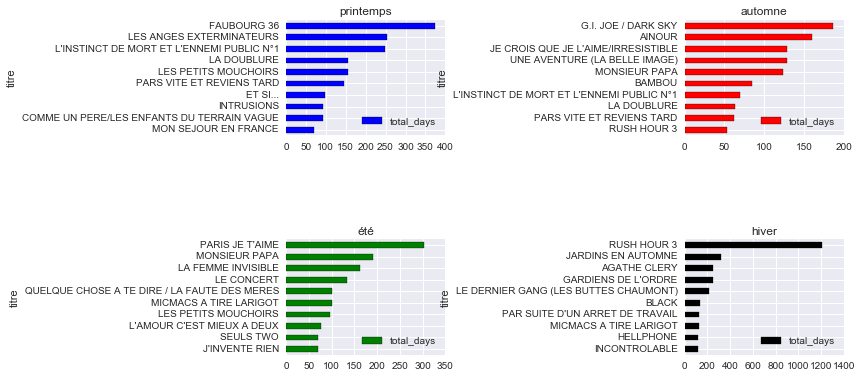

In [15]:
compare_seasons_plot(tournages, 'titre', max_values=10, kind='barh')

# Les films qui se sont étalés sur 4 saisons

In [16]:
tournages.titre.nunique()

743

In [17]:
tournages.groupby('titre')['saisons'].nunique().sort_values(ascending=False).value_counts() / tournages.titre.nunique()

1    0.433378
2    0.270525
3    0.185734
4    0.110363
Name: saisons, dtype: float64

10% des films se sont étalés sur 4 saisons, POLISSE en fait parti !

In [18]:
tournages.groupby('titre')['saisons'].nunique().sort_values(ascending=False).head(5)

titre
POLISSE                4
LE PETIT LIEUTENANT    4
COURSIER               4
LE TUEUR               4
MOMO                   4
Name: saisons, dtype: int64

# FunFacts

* Les arrondissements préférés des tournages entre 2002 et 2010 sont le 16e et le 8e, how chic !
* Les tournages ont le plus souvent lieu en été et le moins souvent en hiver.
* Le record du nombre de jours de tournages est détenu par "RUSH HOUR 3" pour un total de 1327 sessions de tournages ! Presque que 4 fois plus que Faubourg 36 qui détient la seconde place.
* Les équipes de tournages ayant été les plus frigorifiées sont encore une fois les équipes de RUSH HOUR 3 avec 1200 sessions de tournages passées en hiver.



## Attention : une session de tournage est défini comme étant un (jour x lieu).

Autrement dit, un jour calendaire peut compter 10 sessions de tournages si ces dernières ont eu lieu dans des endroits différents.